# Model Training

Unexpectedly, adding conservation as a feature is not helpful.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
phastcons = {}
with open('../anno/hg19.100way.phastCons.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phastcons: phastcons[chrom] = {}
        phastcons[chrom][int(pos)] = float(score)
phylop = {}
with open('../anno/hg19.100way.phyloP100way.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phylop: phylop[chrom] = {}
        phylop[chrom][int(pos)] = float(score)

In [4]:
introns = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        assert bp not in introns[key], bp
        if bp != -1: introns[key] += [bp]

In [5]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)

37110
169182


In [6]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

bases = ['A', 'C', 'G', 'T']

def encode(introns, phastcons, phylop):
    X, y, chroms, coords, strands = [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        c1 = np.array([phastcons[chrom][pos] if pos in phastcons[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        c2 = np.array([phylop[chrom][pos] if pos in phylop[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        
        if strand == '-':
            c1 = c1[::-1]
            c2 = c2[::-1]
        X += [np.hstack([onehot(seq), c1, c2]).reshape(1, L, 6)]

        # Make target
        _y = np.zeros((stop - begin,))
        for bp in bps:
            if strand == '+':
                bp = L + bp - three
            else:
                bp = L - bp + three - 1
            _y[bp] = 1
        y += [_y]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
    return (np.vstack(X), np.vstack(y),
            np.array(chroms), np.array(coords), np.array(strands))

X, y, chroms, threes, strands = encode(known, phastcons, phylop)

print X.shape, y.shape, len(chroms), len(threes), len(strands)

(37110, 70, 6) (37110, 70) 37110 37110 37110


In [7]:
test = np.array(map(lambda x: x == 'chr1', chroms))
valid = np.array(map(lambda x: x in ('chr2', 'chr3', 'chr4', 'chr5'),
                     chroms))
train = np.array([not (t or v) for t, v in zip(test, valid)])
print sum(test),  sum(valid), sum(train)

X_train, X_valid, X_test = X[train], X[valid], X[test]
y_train, y_valid, y_test = y[train], y[valid], y[test]
print X_train.shape, X_valid.shape, X_test.shape
print y_train.shape, y_valid.shape, y_test.shape

4306 7093 25711
(25711, 70, 6) (7093, 70, 6) (4306, 70, 6)
(25711, 70) (7093, 70) (4306, 70)


In [8]:
def matching(preds, true):
    total, match = 0, 0
    for p, t in zip(preds, true):
        if np.argmax(p) in np.nonzero(t)[0]:
            match += 1
        total += 1
    return match, total

# Compute PWM as sanity check

In [9]:
K = 3
counts = np.zeros((2*K+1, 4))
for target, seq in zip(y_train, X_train):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
print counts.T

[[  5543.   4025.   6580.  30750.   7524.   8726.   7128.]
 [ 15038.   6727.  13676.   3718.  13751.  12028.  11222.]
 [  6480.   5016.   8802.   1699.   6906.   6065.   7984.]
 [ 11990.  23283.   9993.   2884.  10870.  12232.  12717.]]


# Look at cons

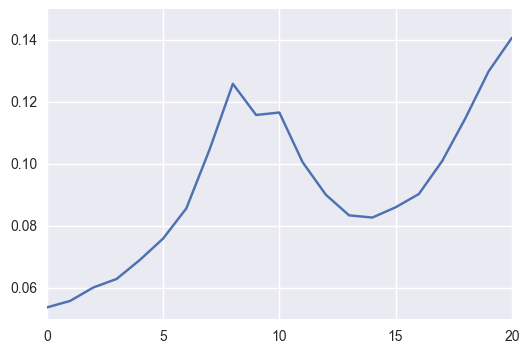

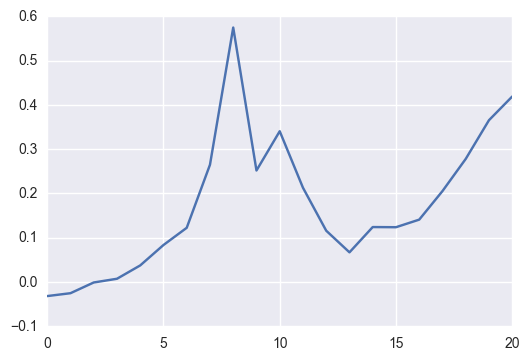

In [10]:
K = 10
counts = np.zeros((2*K+1))
total = 0.0
for target, seq in zip(y_train, X_train):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, 4]
        total += 1.0
plt.plot(counts / total)
plt.show()

K = 10
counts = np.zeros((2*K+1))
total = 0.0
for target, seq in zip(y_train, X_train):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, 5]
        total += 1.0
plt.plot(counts / total)
plt.show()

# Model trainer

In [11]:
class ModelTrainer:
    def __init__(self, model):
        self.model = model
        self.train_auc = []
        self.train_match = []
        self.valid_auc = []
        self.valid_match = []
        
    def train(self, X_train, X_valid,
              y_train, y_valid, PATIENCE = 10, EPOCHS = 1000):
        print model.summary()
        for i in range(EPOCHS):
            model.fit(X_train, y_train, epochs = 1, verbose = 0)
            self._evaluate(X_train, X_valid, y_train, y_valid)
            if (i > PATIENCE
                and max(self.valid_auc[-PATIENCE:])
                < max(self.valid_auc)):
                break
            print i, self.valid_match[-1], self.train_match[-1]
        self._plot_scores()
        print max(self.valid_match), max(self.valid_auc)
    
    def predict(X):
        return self.model.predict(X)
                
    def _evaluate(self, X_train, X_valid, y_train, y_valid):
        valid_preds = self.model.predict_proba(X_valid, verbose=0)
        train_preds = self.model.predict_proba(X_train, verbose=0)
        self.valid_match += [matching(valid_preds, y_valid)[0]
                             / float(y_valid.shape[0])]
        self.train_match += [matching(train_preds, y_train)[0]
                             / float(y_train.shape[0])]
        self.valid_auc += [metrics.roc_auc_score(y_valid.flatten(),
                                                 valid_preds.flatten())]
        self.train_auc += [metrics.roc_auc_score(y_train.flatten(),
                                                 train_preds.flatten())]
    
    def _plot_scores(self):
        plt.plot(self.valid_match, label = 'Validation')
        plt.plot(self.train_match, label = 'Training')
        plt.ylabel('Match')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
        
        plt.plot(self.valid_auc, label = 'Validation')
        plt.plot(self.train_auc, label = 'Training')
        plt.ylabel('auROC')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, LSTM, Dropout
from keras.layers.convolutional import Conv2D
from keras import regularizers
from keras import optimizers
from keras.layers.wrappers import Bidirectional, TimeDistributed

Using Theano backend.


0 28 0.001 0.05 0.05 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 70, 56)            7392      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 70, 1)             57        
Total params: 7,449
Trainable params: 7,449
Non-trainable params: 0
_________________________________________________________________
None
0 0.490624559425 0.533895997822
1 0.551247709009 0.60040449613
2 0.580854363457 0.627202364747
3 0.594388834062 0.636770253977
4 0.605526575497 0.643848936253
5 0.61102495418 0.652872311462
6 0.615536444382 0.659562055151
7 0.622726631891 0.66162342966
8 0.620893838996 0.662945820855
9 0.626533201748 0.669635564544
10 0.624559424785 0.669285519816
11 0.632313548569 0.67208587764
12 0.633300437051 0.676792034538
13 0.626392217679 0.67441950916
14 0.632454532638 0.678658939753
15 0.640208656422 0.68390961

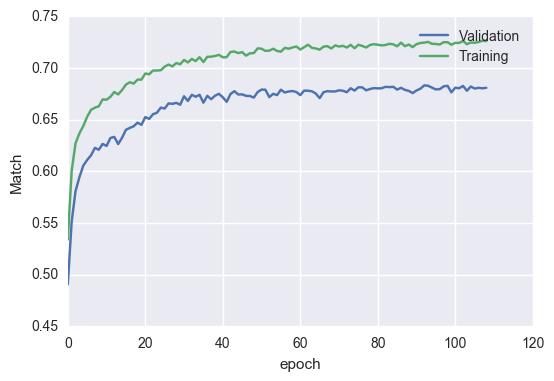

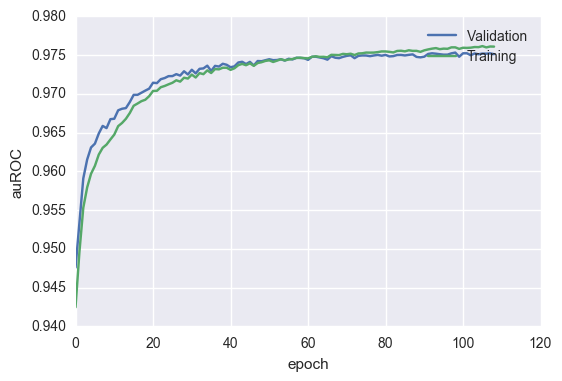

0.683208797406 0.975323446561
0 32 0.001 0.05 0.05 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 70, 64)            9472      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 70, 1)             65        
Total params: 9,537
Trainable params: 9,537
Non-trainable params: 0
_________________________________________________________________
None
0 0.442408007895 0.489401423515
1 0.536162413647 0.576173622185
2 0.580572395319 0.624246431488
3 0.574933032567 0.625957761269
4 0.583815028902 0.632686398818
5 0.601860989708 0.646649294076
6 0.613139715212 0.655517093851
7 0.629916819399 0.667107463731
8 0.639785704215 0.67585858193
9 0.641477513041 0.680564738828
10 0.639362752009 0.68138150986
11 0.638375863527 0.680525844969
12 0.650641477513 0.690288203493
13 0.65332017482 0.692155108708
14 0.650641477513 0.692271790

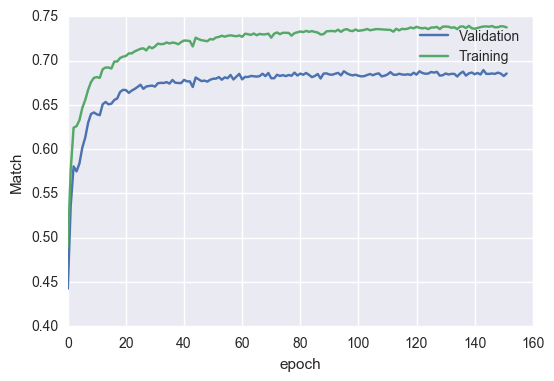

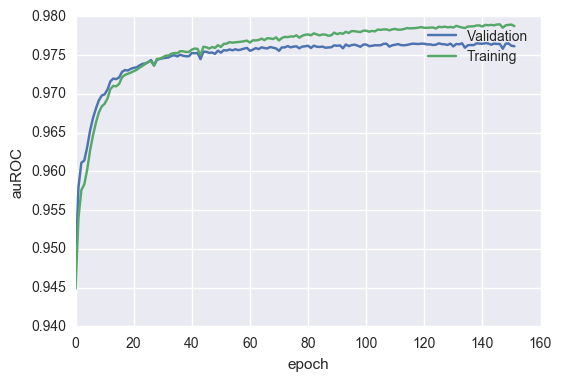

0.689271112364 0.976526092738
0 26 0.001 0.05 0.05 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 70, 52)            6448      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 70, 1)             53        
Total params: 6,501
Trainable params: 6,501
Non-trainable params: 0
_________________________________________________________________
None
0 0.450867052023 0.492824083077
1 0.540250951642 0.589319746412
2 0.580854363457 0.624907627086
3 0.58874947131 0.633308700556
4 0.608064288735 0.646493718642
5 0.620047934583 0.657772937653
6 0.625828281404 0.663879273463
7 0.617933173551 0.661040021781
8 0.627802058367 0.669246625958
9 0.630903707881 0.674964023181
10 0.635133229945 0.677647699428
11 0.626674185817 0.673602738128
12 0.638516847596 0.682976158065
13 0.632736500775 0.678658939753
14 0.636825038771 0.6857376

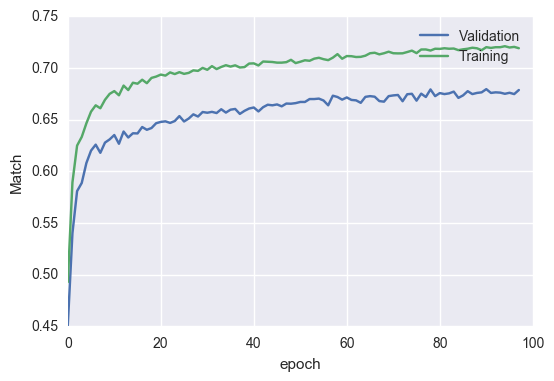

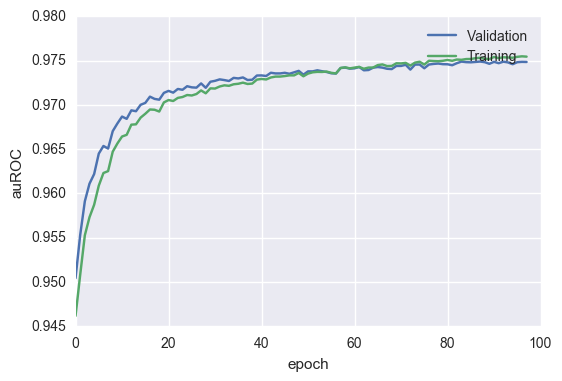

0.679543211617 0.974895349024
0 28 0.001 0.05 0.05 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 70, 56)            7392      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 70, 56)            19040     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 70, 1)             57        
Total params: 26,489
Trainable params: 26,489
Non-trainable params: 0
_________________________________________________________________
None
0 0.524742704074 0.56559449263
1 0.586916678415 0.631519583058
2 0.605244607359 0.652911205321
3 0.623290568166 0.667885340905
4 0.636543070633 0.68079810198
5 0.650641477513 0.687137800941
6 0.648385732412 0.686943331648
7 0.656703792471 0.691338337676
8 0.660933314535 0.695538874412
9 0.664457916255 0.698261444518
10 0.669110390526 0.702345

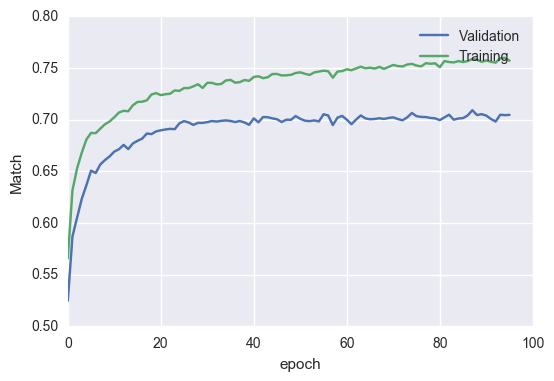

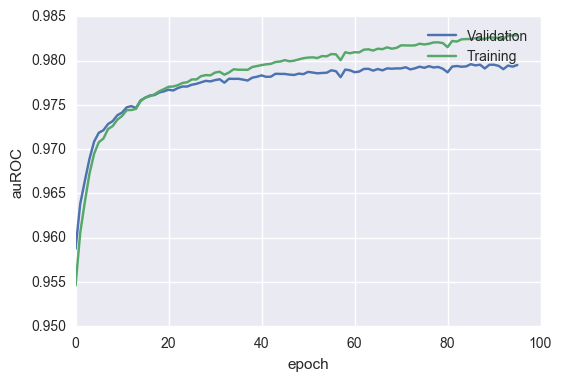

0.709149866065 0.979598643765
0 32 0.001 0.05 0.05 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_7 (Bidirection (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 70, 1)             65        
Total params: 34,369
Trainable params: 34,369
Non-trainable params: 0
_________________________________________________________________
None
0 0.550401804596 0.595659445374
1 0.594529818131 0.636459103108
2 0.593683913718 0.644860176578
3 0.622867615959 0.666212904982
4 0.636684054702 0.68138150986
5 0.64627097138 0.684454124694
6 0.651064429719 0.692349578002
7 0.654448047371 0.698066975225
8 0.664175948118 0.70285091984
9 0.674185817003 0.709774026681
10 0.671366135627 0.7127688

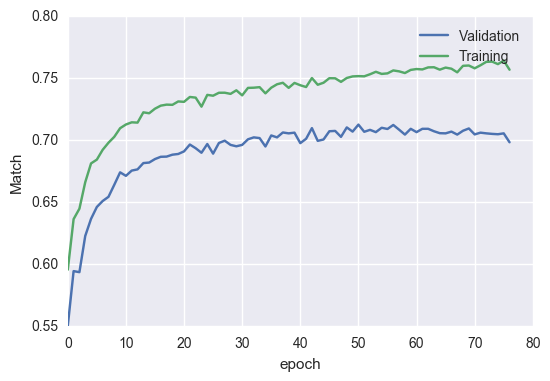

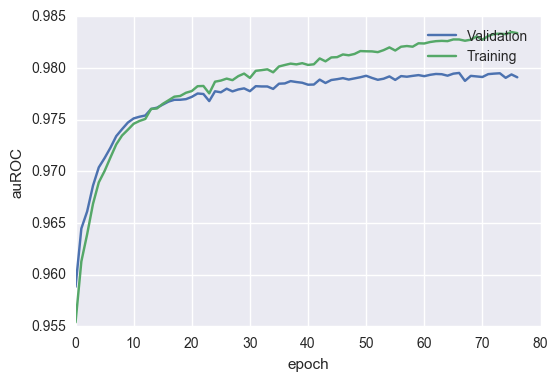

0.712674467785 0.97952247726
0 26 0.001 0.05 0.05 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_8 (Bidirection (None, 70, 52)            6448      
_________________________________________________________________
bidirectional_9 (Bidirection (None, 70, 52)            16432     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 70, 1)             53        
Total params: 22,933
Trainable params: 22,933
Non-trainable params: 0
_________________________________________________________________
None
0 0.505427886649 0.539574501186
1 0.591851120823 0.638442689899
2 0.609051177217 0.65582824472
3 0.622585647822 0.66975224612
4 0.638798815734 0.681537085294
5 0.642323417454 0.685893197464
6 0.651064429719 0.690093734199
7 0.651487381926 0.691649488546
8 0.659100521641 0.69499436039
9 0.657549696884 0.693477499903
10 0.662343155223 0.69923379

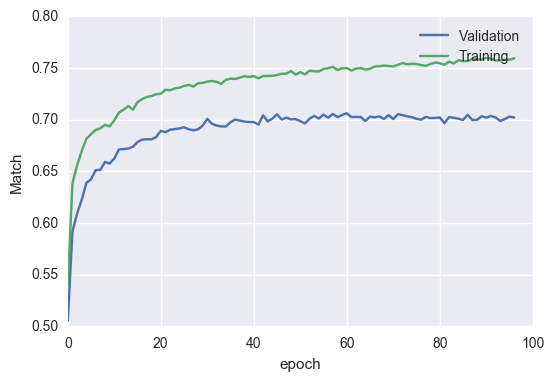

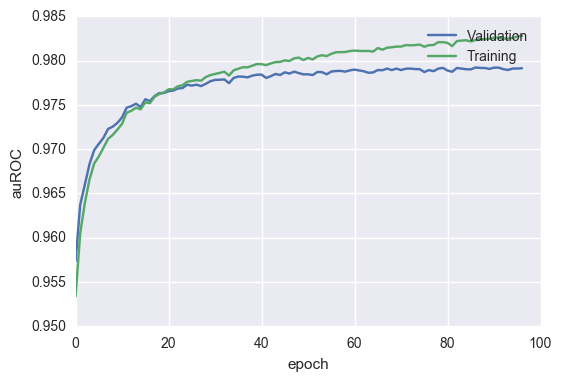

0.70618920062 0.979221209282
0 28 0.001 0.05 0.05 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 70, 56)            7392      
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 70, 56)            19040     
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 70, 56)            19040     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 70, 1)             57        
Total params: 45,529
Trainable params: 45,529
Non-trainable params: 0
_________________________________________________________________
None
0 0.525024672212 0.566800202248
1 0.600310164951 0.643148846797
2 0.618638093895 0.661973474388
3 0.633018468913 0.672863754813
4 0.64627097138 0.684493018552
5 0.652897222614 0.690560460503
6 0.655293951783 0.696

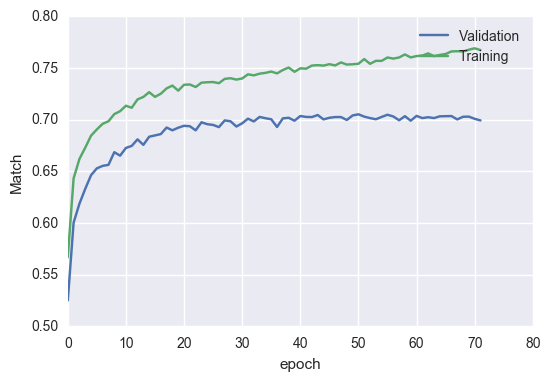

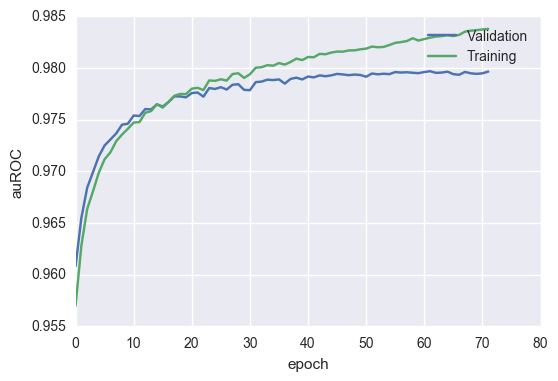

0.705202312139 0.979690879151
0 32 0.001 0.05 0.05 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_13 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 70, 1)             65        
Total params: 59,201
Trainable params: 59,201
Non-trainable params: 0
_________________________________________________________________
None
0 0.471591710137 0.523200186691
1 0.583956012971 0.630663918167
2 0.607077400254 0.651511026409
3 0.621316791203 0.664929407647
4 0.645566051036 0.681303722142
5 0.654025095164 0.691493913111
6 0.653602142958 0.6

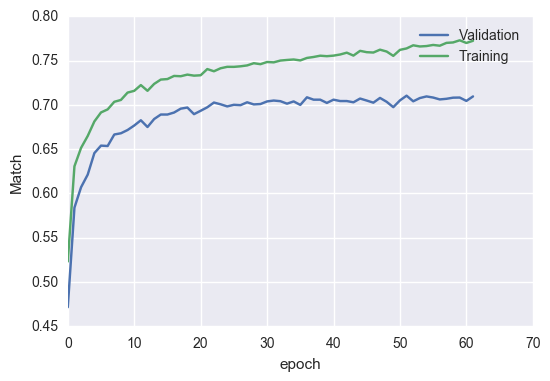

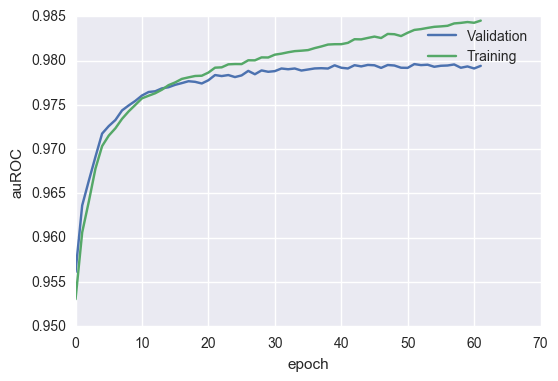

0.710418722684 0.979606709088
0 26 0.001 0.05 0.05 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_16 (Bidirectio (None, 70, 52)            6448      
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 70, 52)            16432     
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 70, 52)            16432     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 70, 1)             53        
Total params: 39,365
Trainable params: 39,365
Non-trainable params: 0
_________________________________________________________________
None
0 0.504581982236 0.548286725526
1 0.582969124489 0.630274979581
2 0.582264204145 0.635253393489
3 0.619061046102 0.667185251449
4 0.648526716481 0.688110147408
5 0.654025095164 0.695383298977
6 0.662343155223 0.7

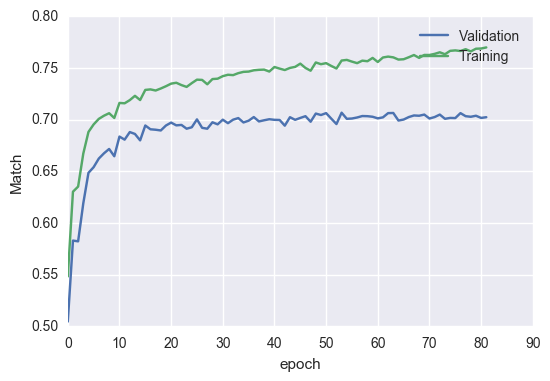

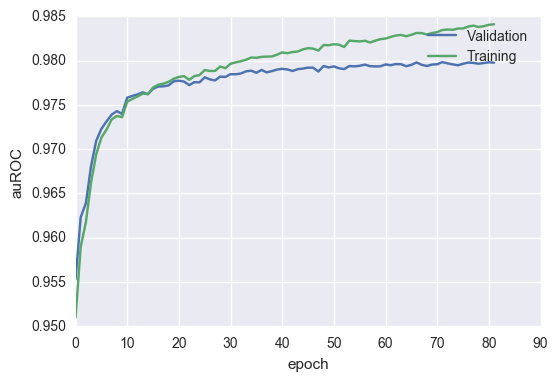

0.706753136896 0.979833938565
0 28 0.001 0.1 0.05 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_19 (Bidirectio (None, 70, 56)            7392      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 70, 1)             57        
Total params: 7,449
Trainable params: 7,449
Non-trainable params: 0
_________________________________________________________________
None
0 0.438037501762 0.489712574385
1 0.493021288594 0.537785383688
2 0.554208374454 0.599743300533
3 0.573946144086 0.620862665785
4 0.581559283801 0.633036443546
5 0.597349499507 0.638520477617
6 0.590723248273 0.636303527673
7 0.611165938249 0.650577573801
8 0.616241364726 0.659445373576
9 0.628788946849 0.667924234763
10 0.634710277739 0.672008089923
11 0.637107006908 0.67702539769
12 0.642182433385 0.679981330948
13 0.645425066967 0.685893197464
14 0.646552939518 0.68659328

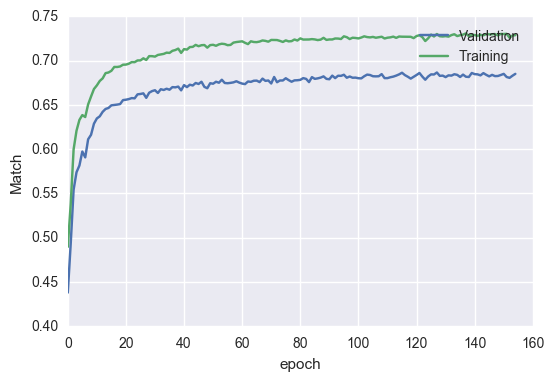

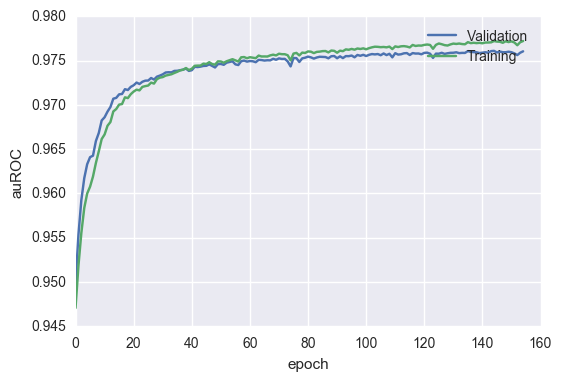

0.686592415057 0.976101221069
0 32 0.001 0.1 0.05 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_20 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 70, 1)             65        
Total params: 9,537
Trainable params: 9,537
Non-trainable params: 0
_________________________________________________________________
None
0 0.442830960102 0.49332970324
1 0.47596221627 0.520049784139
2 0.554067390385 0.59954883124
3 0.556182151417 0.610983625686
4 0.582264204145 0.627630197192
5 0.598336387988 0.638326008323
6 0.600028196814 0.643693360818
7 0.613562667419 0.651938858854
8 0.630057803468 0.668507642643
9 0.635274214014 0.673563844269
10 0.628225010574 0.669791139979
11 0.641054560835 0.680875889697
12 0.639644720147 0.68600987904
13 0.647821796137 0.687371164093
14 0.653461158889 0.69126054995

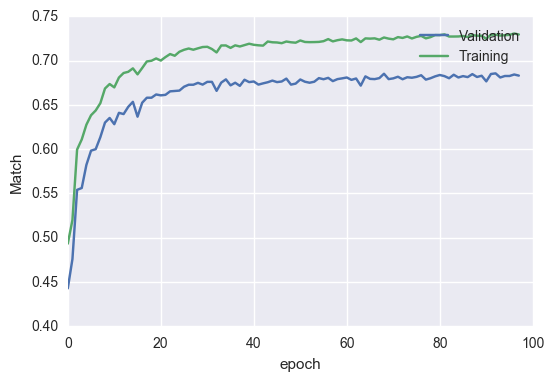

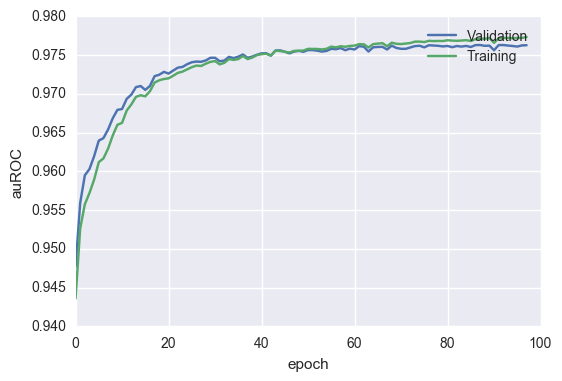

0.685605526575 0.976298446946
0 26 0.001 0.1 0.05 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_21 (Bidirectio (None, 70, 52)            6448      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 70, 1)             53        
Total params: 6,501
Trainable params: 6,501
Non-trainable params: 0
_________________________________________________________________
None
0 0.414070210066 0.463070281203
1 0.502326237135 0.541947026565
2 0.570421542366 0.609000038894
3 0.569857606091 0.616234296605
4 0.590582264204 0.631519583058
5 0.592697025236 0.634981136479
6 0.598054419851 0.641709774027
7 0.612011842662 0.64769942826
8 0.605949527703 0.647738322119
9 0.626533201748 0.664345999767
10 0.628084026505 0.666057329548
11 0.627097138023 0.667885340905
12 0.63456929367 0.67383610128
13 0.635838150289 0.675352961767
14 0.637811927252 0.6772587608

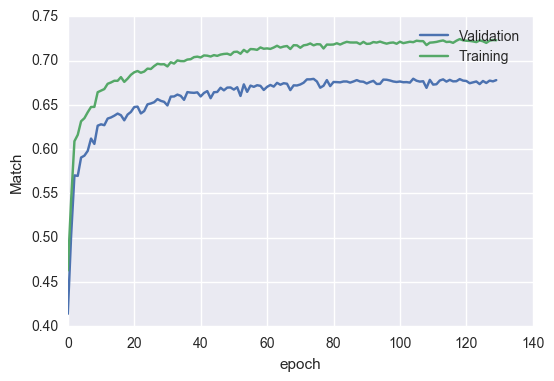

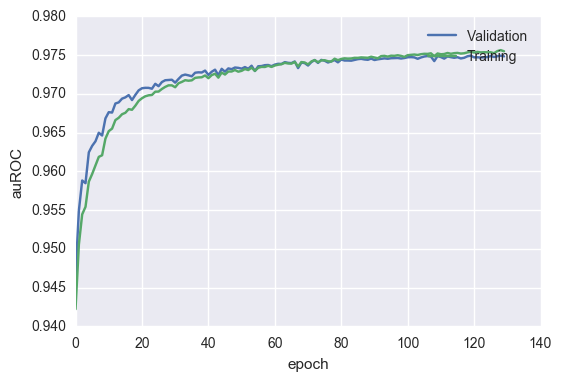

0.679543211617 0.974925365138
0 28 0.001 0.1 0.05 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_22 (Bidirectio (None, 70, 56)            7392      
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 70, 56)            19040     
_________________________________________________________________
time_distributed_13 (TimeDis (None, 70, 1)             57        
Total params: 26,489
Trainable params: 26,489
Non-trainable params: 0
_________________________________________________________________
None
0 0.493726208938 0.53945781961
1 0.563231354857 0.608455524873
2 0.596080642887 0.641515304733
3 0.617933173551 0.655672669286
4 0.633300437051 0.67410835829
5 0.633159452982 0.675975263506
6 0.644720146623 0.686359923768
7 0.653602142958 0.694877678815
8 0.654448047371 0.69935047256
9 0.658254617228 0.701295165493
10 0.664175948118 0.70460114

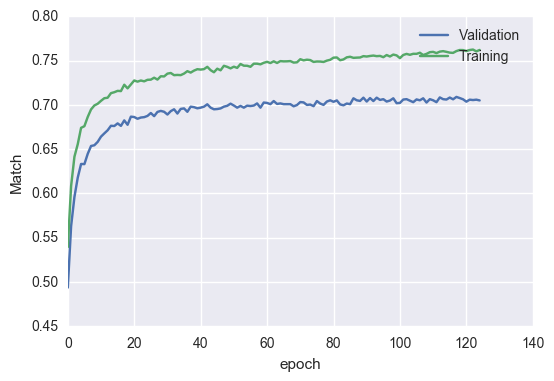

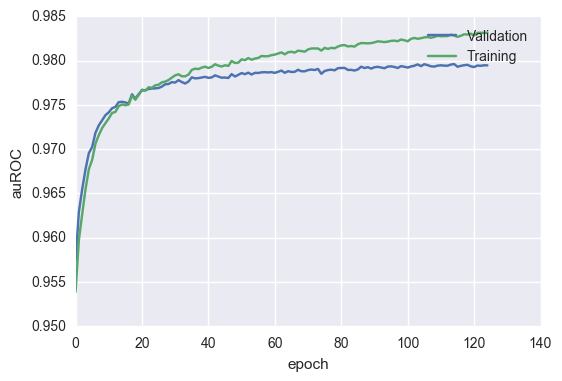

0.709008881996 0.979608605571
0 32 0.001 0.1 0.05 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_24 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_14 (TimeDis (None, 70, 1)             65        
Total params: 34,369
Trainable params: 34,369
Non-trainable params: 0
_________________________________________________________________
None
0 0.535598477372 0.585585935981
1 0.583251092627 0.636770253977
2 0.60637247991 0.65119987554
3 0.630057803468 0.673136011824
4 0.647680812068 0.683442884369
5 0.648244748343 0.688304616701
6 0.655575919921 0.693049667458
7 0.658536585366 0.694060907783
8 0.657972649091 0.69472210338
9 0.665021852531 0.701878573373
10 0.669392358663 0.70689588

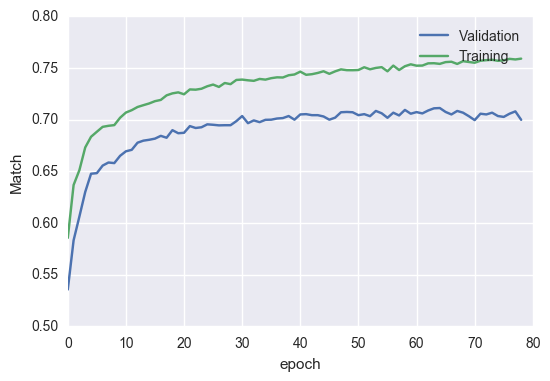

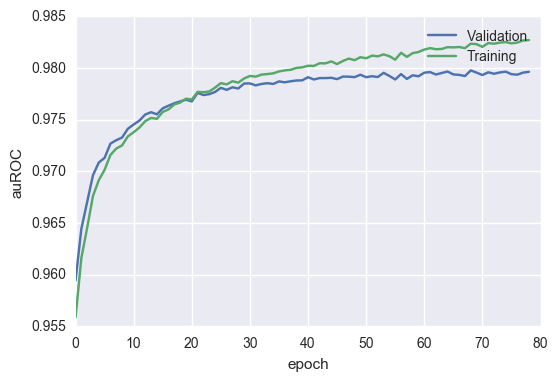

0.711264627097 0.979765405524
0 26 0.001 0.1 0.05 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_26 (Bidirectio (None, 70, 52)            6448      
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 70, 52)            16432     
_________________________________________________________________
time_distributed_15 (TimeDis (None, 70, 1)             53        
Total params: 22,933
Trainable params: 22,933
Non-trainable params: 0
_________________________________________________________________
None
0 0.500916396447 0.542491540586
1 0.550260820527 0.601882462759
2 0.591005216411 0.638753840769
3 0.612434794868 0.654155808798
4 0.626110249542 0.666990782155
5 0.63922176794 0.678658939753
6 0.647539827999 0.685815409747
7 0.636825038771 0.676830928396
8 0.649513604963 0.690404885069
9 0.655293951783 0.693866438489
10 0.662907091499 0.698378

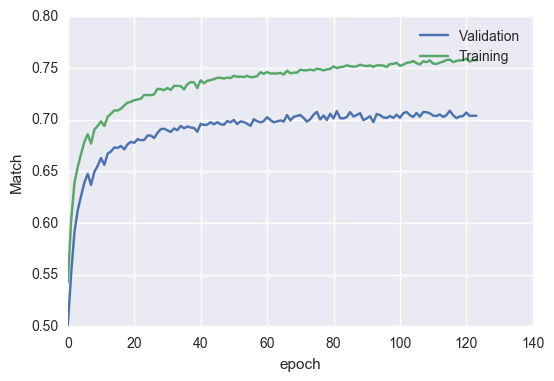

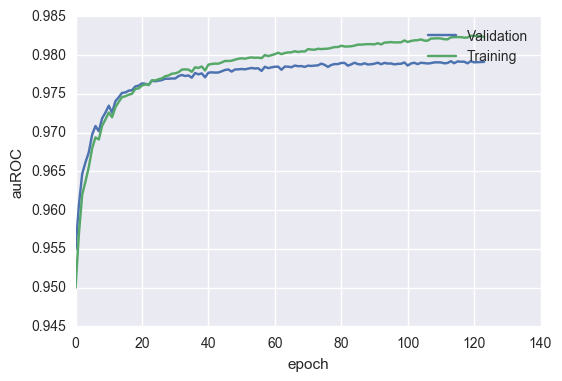

0.708726913859 0.979211906921
0 28 0.001 0.1 0.05 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_28 (Bidirectio (None, 70, 56)            7392      
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 70, 56)            19040     
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 70, 56)            19040     
_________________________________________________________________
time_distributed_16 (TimeDis (None, 70, 1)             57        
Total params: 45,529
Trainable params: 45,529
Non-trainable params: 0
_________________________________________________________________
None
0 0.519526293529 0.565983431216
1 0.583251092627 0.629847147135
2 0.607782320598 0.651511026409
3 0.630198787537 0.671191318891
4 0.640349640491 0.681537085294
5 0.630621739743 0.673213799541
6 0.656280840265 0.69

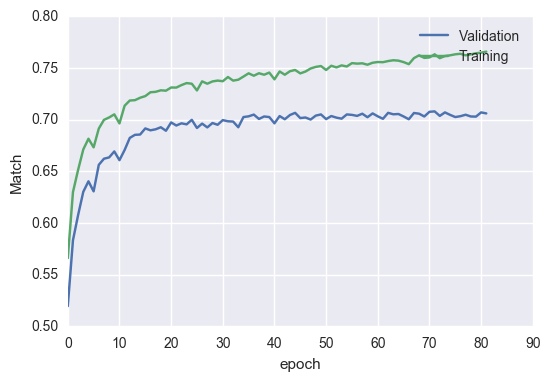

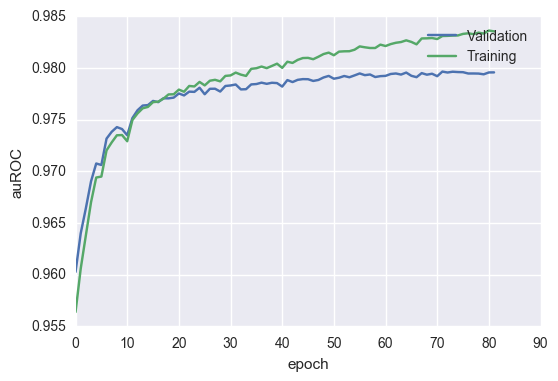

0.708021993515 0.97965243933
0 32 0.001 0.1 0.05 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_31 (Bidirectio (None, 70, 64)            9472      
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_17 (TimeDis (None, 70, 1)             65        
Total params: 59,201
Trainable params: 59,201
Non-trainable params: 0
_________________________________________________________________
None
0 0.539123079092 0.580996460659
1 0.546736218807 0.605810742484
2 0.602142957846 0.647660534402
3 0.602565910052 0.651822177278
4 0.638798815734 0.674497296877
5 0.659946426054 0.693127455175
6 0.665585788806 0.703

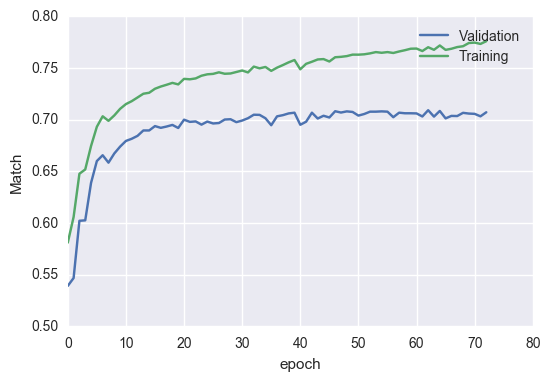

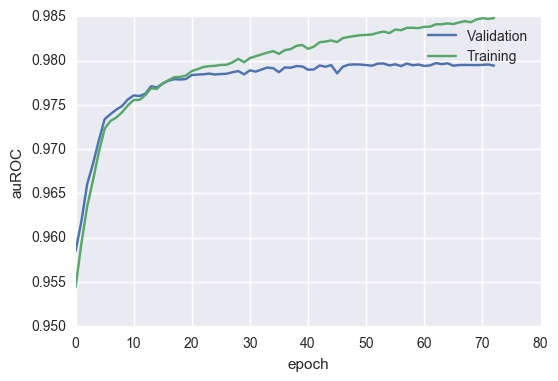

0.709149866065 0.979724072283
0 26 0.001 0.1 0.05 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_34 (Bidirectio (None, 70, 52)            6448      
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 70, 52)            16432     
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 70, 52)            16432     
_________________________________________________________________
time_distributed_18 (TimeDis (None, 70, 1)             53        
Total params: 39,365
Trainable params: 39,365
Non-trainable params: 0
_________________________________________________________________
None
0 0.510080360919 0.559877095407
1 0.553080501903 0.604527245148
2 0.612011842662 0.655983820155
3 0.623713520372 0.668507642643
4 0.640208656422 0.68048695111
5 0.64866770055 0.68978258333
6 0.653038206683 0.69433

KeyboardInterrupt: 

In [13]:
num_layers = [1, 2, 3]
l2s = [0, 0.00001, 0.001, 0.01]
hiddens = [28, 32, 26]
lrs = [0.001, 0.0005, 0.0001]
dropouts = [0.05, 0.1, 0.15, 0.2]
r_dropouts = [0.05]

for l2 in l2s:
    for lr in lrs:
        for dropout in dropouts:
            for r_dropout in r_dropouts:
                for num_layer in num_layers:
                    for hidden in hiddens:
                        print l2, hidden, lr, dropout, r_dropout, num_layer
                        model = Sequential()
                        reg = regularizers.l2(l2)

                        model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                                       dropout = dropout, recurrent_dropout = r_dropout,
                                                       kernel_regularizer = reg,
                                                       recurrent_regularizer = reg),
                                                 input_shape=(L, 4)))
                        for _ in range(num_layer-1):
                            model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                                           dropout = dropout, recurrent_dropout = r_dropout,
                                                           kernel_regularizer = reg,
                                                           recurrent_regularizer = reg)))

                        model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
                        model.compile(loss='binary_crossentropy',
                                      optimizer=optimizers.Adam(lr=lr,
                                                                beta_1=0.9,
                                                                beta_2=0.999,
                                                                epsilon=1e-08,
                                                                decay=0.0))
                        ModelTrainer(model).train(X_train[:, :, :4], X_valid[:, :, :4],
                                                  y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))

0 28 0.001 0.15 0.05 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_38 (Bidirectio (None, 70, 56)            7840      
_________________________________________________________________
bidirectional_39 (Bidirectio (None, 70, 56)            19040     
_________________________________________________________________
time_distributed_20 (TimeDis (None, 70, 1)             57        
Total params: 26,937
Trainable params: 26,937
Non-trainable params: 0
_________________________________________________________________
None
0 0.514873819258 0.558476916495
1 0.586775694347 0.63202520322
2 0.605808543635 0.657539574501
3 0.618215141689 0.664307105908
4 0.630480755675 0.677686593287
5 0.63922176794 0.681964917739
6 0.643310305935 0.684804169422
7 0.658254617228 0.694955466532
8 0.656985760609 0.697483567345
9 0.663048075567 0.70370658473
10 0.668123502044 0.705145657501
11 0.671507119695 0.7090

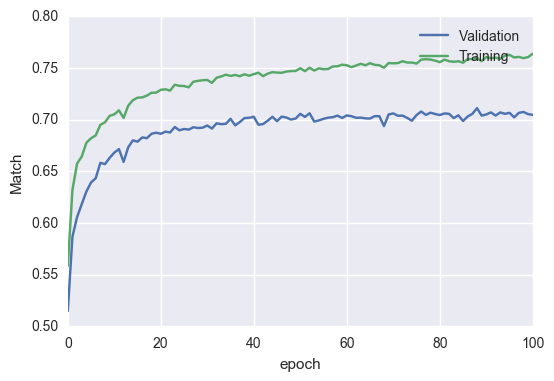

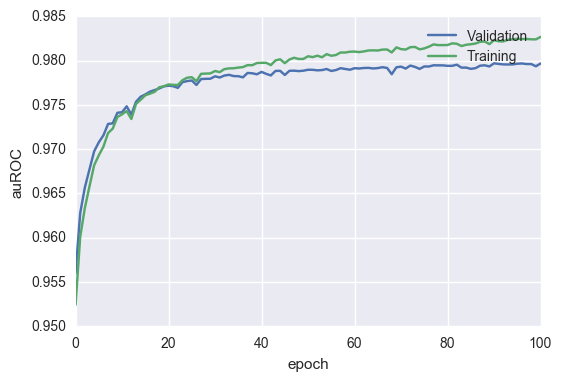

0.711123643028 0.979695597194
0 32 0.001 0.15 0.05 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_40 (Bidirectio (None, 70, 64)            9984      
_________________________________________________________________
bidirectional_41 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_21 (TimeDis (None, 70, 1)             65        
Total params: 34,881
Trainable params: 34,881
Non-trainable params: 0
_________________________________________________________________
None
0 0.552798533766 0.597954183034
1 0.603411814465 0.649838590487
2 0.624559424785 0.667263039166
3 0.642182433385 0.684959744856
4 0.654166079233 0.695383298977
5 0.659523473847 0.698728170822
6 0.662484139292 0.702889813698
7 0.666149725081 0.708101590759
8 0.672775976315 0.71300221695
9 0.664880868462 0.705729065381
10 0.676582546172 0.71813

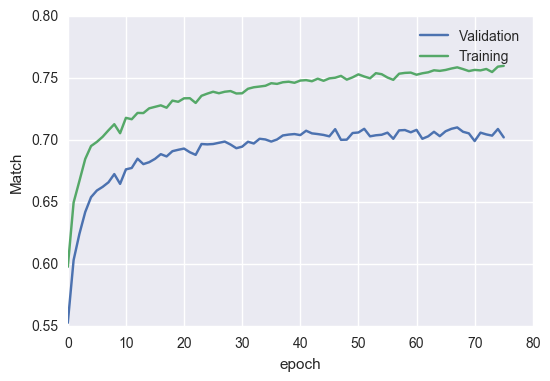

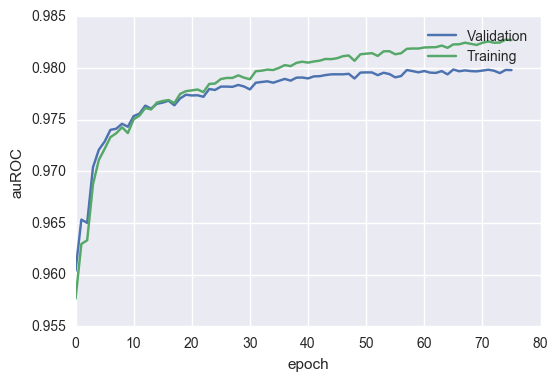

0.710418722684 0.97985513383
0 26 0.001 0.15 0.05 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_42 (Bidirectio (None, 70, 52)            6864      
_________________________________________________________________
bidirectional_43 (Bidirectio (None, 70, 52)            16432     
_________________________________________________________________
time_distributed_22 (TimeDis (None, 70, 1)             53        
Total params: 23,349
Trainable params: 23,349
Non-trainable params: 0
_________________________________________________________________
None
0 0.548428027633 0.594842674342
1 0.589313407585 0.632258566372
2 0.594952770337 0.641009684571
3 0.626110249542 0.670180078566
4 0.6321725645 0.677842168722
5 0.638939799803 0.678931196764
6 0.642464401523 0.687410057952
7 0.649090652756 0.688654661429
8 0.657408712815 0.696627902454
9 0.656703792471 0.699817198864
10 0.664175948118 0.7043677

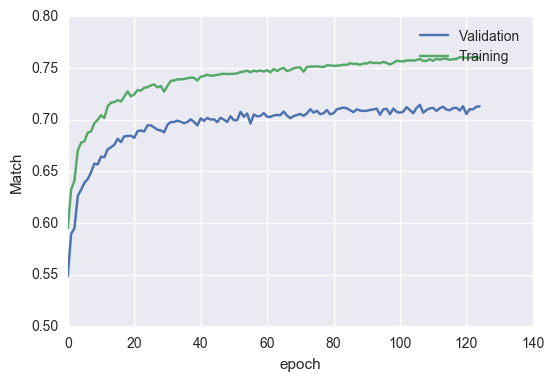

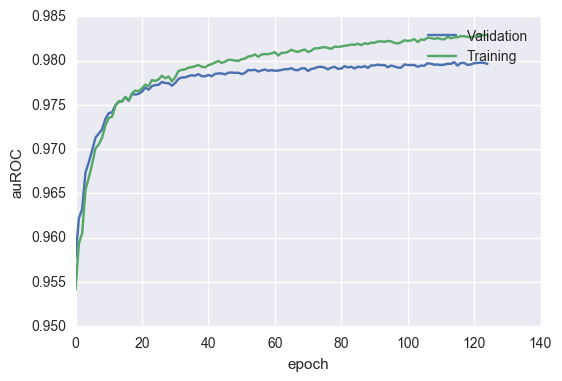

0.714366276611 0.979829721917
0 28 0.001 0.15 0.05 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_44 (Bidirectio (None, 70, 56)            7840      
_________________________________________________________________
bidirectional_45 (Bidirectio (None, 70, 56)            19040     
_________________________________________________________________
bidirectional_46 (Bidirectio (None, 70, 56)            19040     
_________________________________________________________________
time_distributed_23 (TimeDis (None, 70, 1)             57        
Total params: 45,977
Trainable params: 45,977
Non-trainable params: 0
_________________________________________________________________
None
0 0.50415903003 0.558126871767
1 0.580149443113 0.624363113064
2 0.588608487241 0.638598265334
3 0.622162695615 0.661467854226
4 0.63104469195 0.672397028509
5 0.643733258142 0.683598459803
6 0.654730015508 0.693

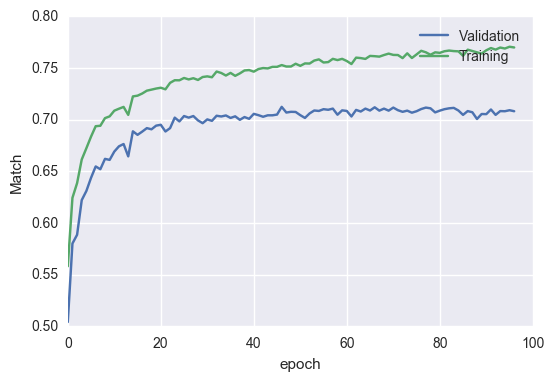

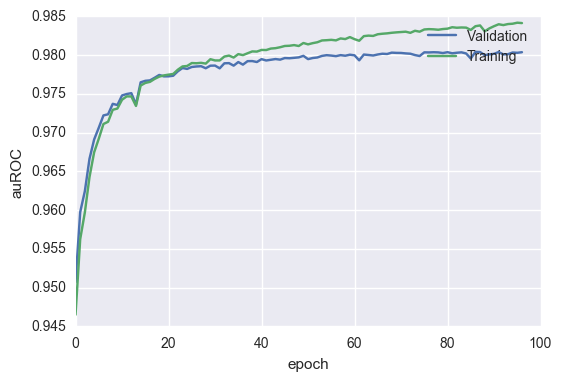

0.712392499648 0.98041732672
0 32 0.001 0.15 0.05 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_47 (Bidirectio (None, 70, 64)            9984      
_________________________________________________________________
bidirectional_48 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
bidirectional_49 (Bidirectio (None, 70, 64)            24832     
_________________________________________________________________
time_distributed_24 (TimeDis (None, 70, 1)             65        
Total params: 59,713
Trainable params: 59,713
Non-trainable params: 0
_________________________________________________________________
None
0 0.556746087692 0.603165960095
1 0.595375722543 0.644198980981
2 0.613562667419 0.659523161293
3 0.627802058367 0.674147252149
4 0.650359509375 0.690443778927
5 0.656139856196 0.696433433161
6 0.661215282673 0.69

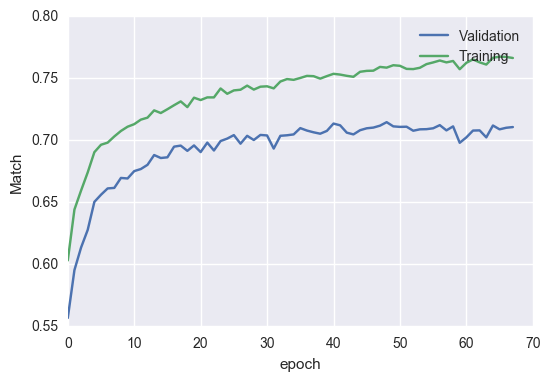

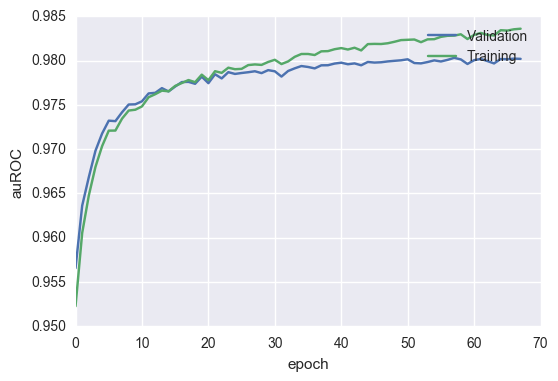

0.714648244748 0.9803118313
0 26 0.001 0.15 0.05 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_50 (Bidirectio (None, 70, 52)            6864      
_________________________________________________________________
bidirectional_51 (Bidirectio (None, 70, 52)            16432     
_________________________________________________________________
bidirectional_52 (Bidirectio (None, 70, 52)            16432     
_________________________________________________________________
time_distributed_25 (TimeDis (None, 70, 1)             53        
Total params: 39,781
Trainable params: 39,781
Non-trainable params: 0
_________________________________________________________________
None
0 0.50415903003 0.563221967251
1 0.598054419851 0.638870522345
2 0.620611870859 0.669557776827
3 0.635979134358 0.677919956439
4 0.654589031439 0.693205242892
5 0.653461158889 0.692932985882
6 0.663471027774 0.7010

KeyboardInterrupt: 

In [15]:
num_layers = [2, 3]
l2s = [0, 0.00001, 0.001, 0.01]
hiddens = [28, 32, 26]
lrs = [0.001, 0.0005, 0.0001]
dropouts = [0.15]
r_dropouts = [0.05]

for l2 in l2s:
    for lr in lrs:
        for dropout in dropouts:
            for r_dropout in r_dropouts:
                for num_layer in num_layers:
                    for hidden in hiddens:
                        print l2, hidden, lr, dropout, r_dropout, num_layer
                        model = Sequential()
                        reg = regularizers.l2(l2)

                        model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                                       dropout = dropout, recurrent_dropout = r_dropout,
                                                       kernel_regularizer = reg,
                                                       recurrent_regularizer = reg),
                                                 input_shape=(L, 6)))
                        for _ in range(num_layer-1):
                            model.add(Bidirectional(LSTM(hidden, return_sequences = True,
                                                           dropout = dropout, recurrent_dropout = r_dropout,
                                                           kernel_regularizer = reg,
                                                           recurrent_regularizer = reg)))

                        model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))
                        model.compile(loss='binary_crossentropy',
                                      optimizer=optimizers.Adam(lr=lr,
                                                                beta_1=0.9,
                                                                beta_2=0.999,
                                                                epsilon=1e-08,
                                                                decay=0.0))
                        ModelTrainer(model).train(X_train, X_valid,
                                                  y_train.reshape(-1, 70, 1), y_valid.reshape(-1, 70, 1))